In [1]:
%load_ext autoreload
%autoreload 2

from solve_2_sat import solve_2_sat
from davis_putnam import davis_putnam
from dpll import dpll
from cdcl import cdcl 
from cdcl_6 import cdcl_clause_learning 
from cdcl_7 import cdcl_watched_literals 
from cdcl_8 import cdcl_decision_heuristics_and_restarts 
from cdcl_9 import cdcl_clause_minimization_and_deletion 
import numpy as np
from test_solver import *
from scipy import stats

# Benchmarks

In this notebook I will investigate the performance of the implemented algorithms.

The main metric for this will be the time spent to solve certain input formulas, but other metrics such as the number of unit propagations, decisions or restarts will give further insight into why some algorithms may perform better than others. To get the statistics, the solvers are tested on 100 randomly generated logical formulas and their performance metrics are averaged across those 100 tests. All plots have a log-scale for the y-axis.

## General Comparison of Solvers

### Correctness

First of all though, let's check if the algorithms return correct results for a couple of random formulas. To do so, results are validated against results of the cadical sat solver.

In [2]:
solver_statistics(100,100,2,solve_2_sat)

solvers = [dpll,davis_putnam,cdcl,cdcl_clause_learning,cdcl_watched_literals,cdcl_decision_heuristics_and_restarts,cdcl_clause_minimization_and_deletion]
for n,c,k in [(10,38,3),(1,1,1)]:
        for solver in solvers:
            solver_statistics(n,c,k,solver)

print("All tests passed!")

All tests passed!


### Comparing all solvers

Now let's do a simple comparison of the solver speeds. I will omit the 2_sat_solver from lab 2 for this as it can't solve every formula.

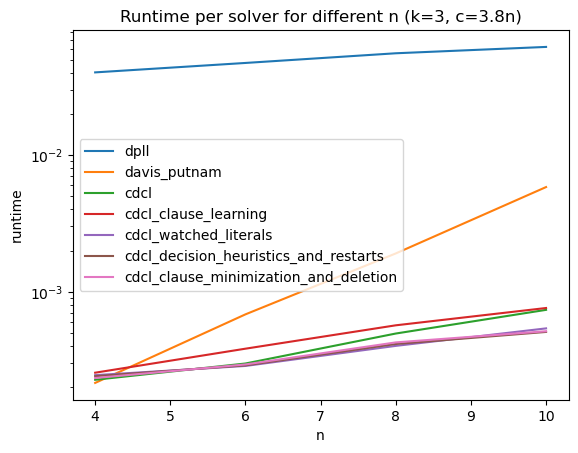

In [ ]:
solvers = [dpll,davis_putnam,cdcl,cdcl_clause_learning,cdcl_watched_literals,cdcl_decision_heuristics_and_restarts,cdcl_clause_minimization_and_deletion]
ns = [4,6,8,10]
all_solver_statistics = get_average_statistics_for_multiple_n(ns,solvers)
plot_statistic(all_solver_statistics,ns,"runtime")

As you can see, dpll is clearly the worst for any formula. Interestingly, for very small formulas, my davis putnam implementation was able to keep up with the cdcl implementation though it quickly falls off with increasing n. Since this shows that dpll and davis putnam are clearly uncompetitive, I will continue with a comparison of only the cdcl implementations.

### Investigation of outliers

Outliers may have a large impact on the results when looking at random samples and using averaging across those tests. Let's have a brief look into how largely this impacts the results when using 100 test cases.

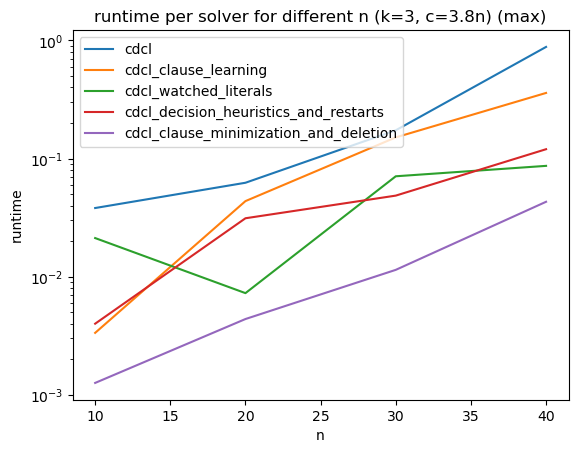

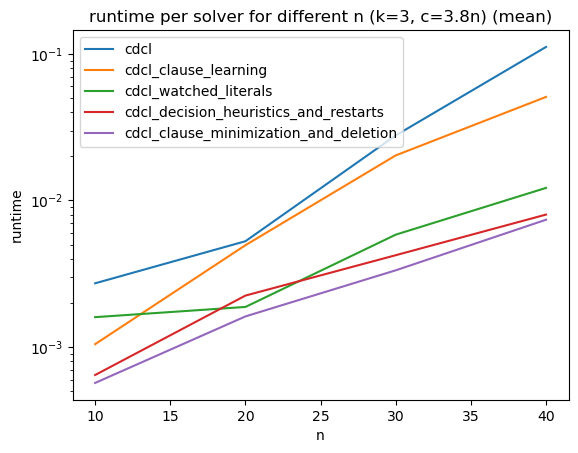

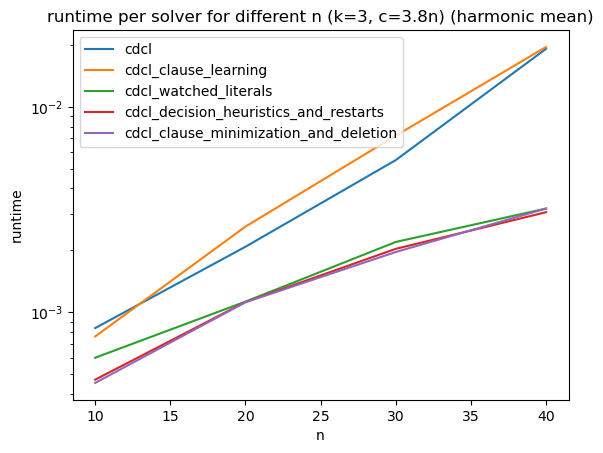

In [21]:
solvers = [cdcl,cdcl_clause_learning,cdcl_watched_literals,cdcl_decision_heuristics_and_restarts,cdcl_clause_minimization_and_deletion]
ns = [10,20,30,40]
outlier_statistics = get_statistics_for_multiple_n(ns,solvers)
plot_statistic(average_statistics(outlier_statistics,averaging_function=np.max),ns,"runtime"," (max)")
plot_statistic(average_statistics(outlier_statistics,averaging_function=np.mean),ns,"runtime"," (mean)")
plot_statistic(average_statistics(outlier_statistics,averaging_function=stats.hmean),ns,"runtime"," (harmonic mean)")

Some outliers of especially hard formulas definitely have an impact even with 100 tests as the maximum values also seem to impact the mean by a lot. Using more tests may create more stable results. 

It could be an idea to use a different averaging method like the harmonic mean that will weight outliers less strongly. But on the other hand, outliers are an essential part of investigating solver performance and should not be neglected. For example, when having to solve a number of completely random formulas, one is likely most interested in the total time needed to solve all of them and using a harmonic mean would not accurately reflect this information need. Therefore I will keep using the arithmetic mean even though it might not yield the most stable results given that I don't want to leave my computer running for an eternity :).

### Comparing the different CDCL iterations

To maintain a decent runtime, I am omitting very long tests.

In [ ]:
solvers = [cdcl,cdcl_clause_learning,cdcl_watched_literals,cdcl_decision_heuristics_and_restarts,cdcl_clause_minimization_and_deletion]
ns = [10,20,30,40,50,60,70,80,90,100,120]
omissions = {90: [cdcl_watched_literals], 60: [cdcl,cdcl_clause_learning]}
cdcl_stats = get_statistics_for_multiple_n(ns,solvers,omissions=omissions)
avg_cdcl_stats = average_statistics(cdcl_stats)

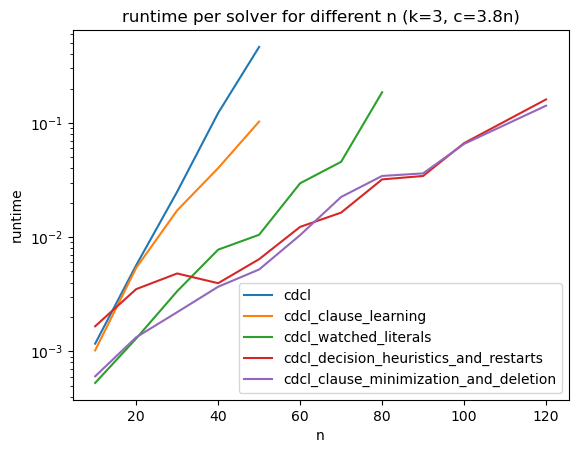

In [7]:
plot_statistic(avg_cdcl_stats,ns,"runtime")

As expected, with every iteration of the cdcl implementations, the runtime improves. Only the last addition of clause minimization and deletion does not seem to offer a particularly great increase in performance compared to its predecessor with decision heuristics and restarts and also performs worse on a lot of formulas. I will give this some further investigation later.

Now let's have a look at statistics propagation_count, decision_count, conflict_count, learned_clause_count, restart_count, deleted_clause_count. These might provide further insights into how the solvers work.

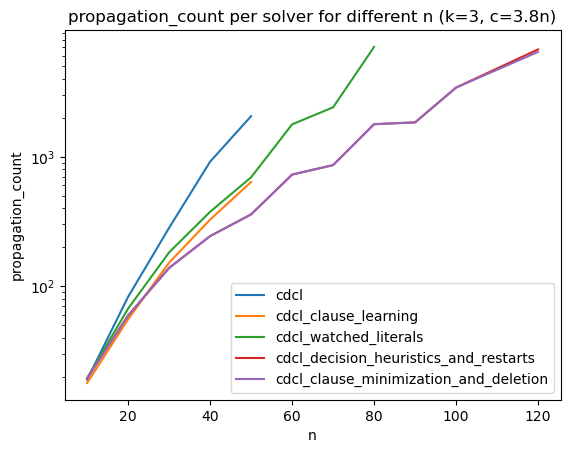

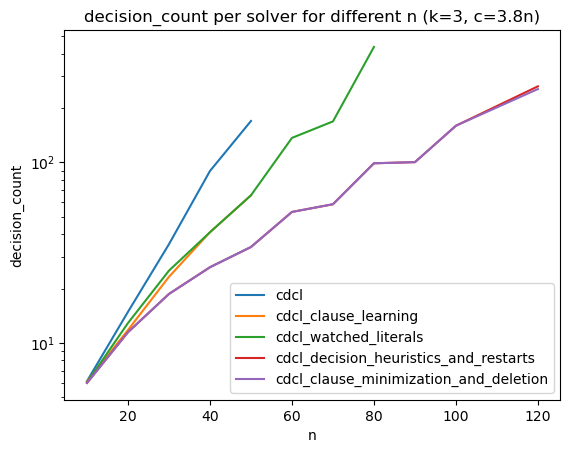

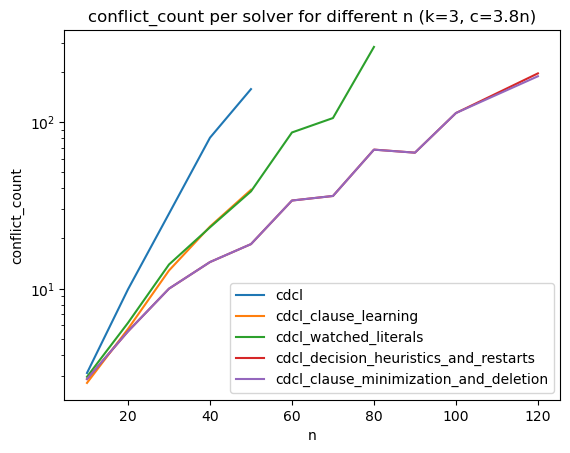

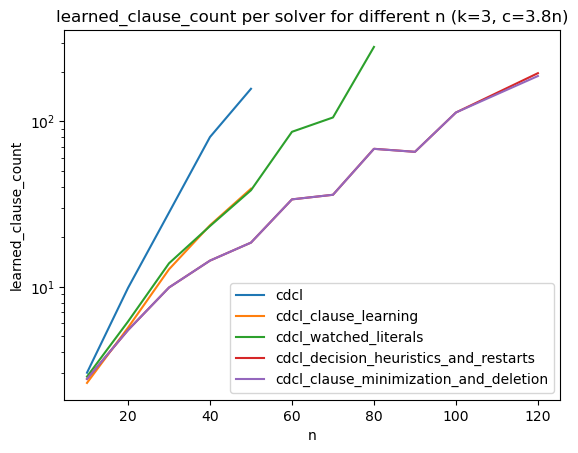

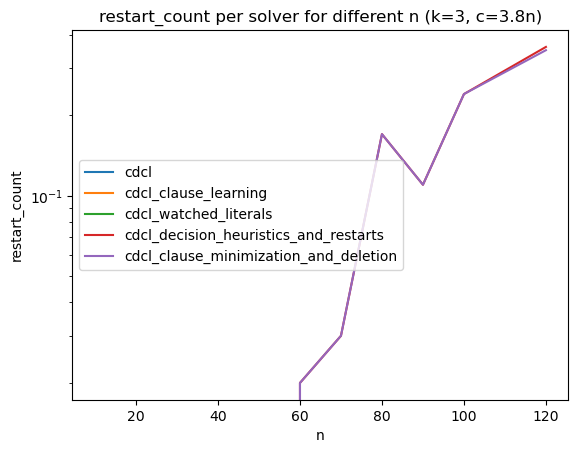

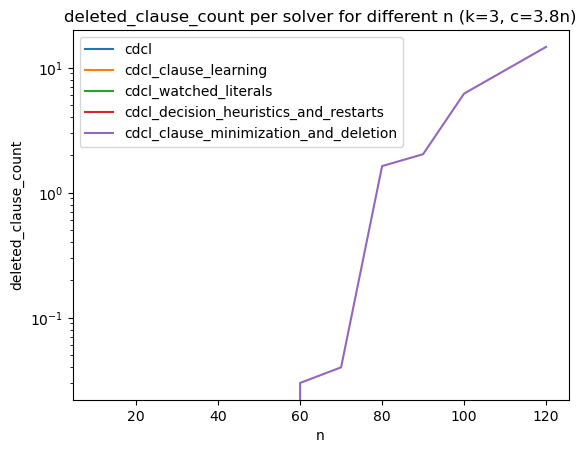

In [8]:
plot_multiple_statistics(avg_cdcl_stats,ns,["propagation_count", "decision_count", "conflict_count", "learned_clause_count", "restart_count", "deleted_clause_count"])

Most of these results are fairly expectable. Increased numbers of propagations, learned clauses, conflicts and decisions seem to be heavily correlated to a worse performance. All of the statistics increase with bigger values of n. It seems that restarts (and therefore also clause deletion) start to be applied around values of n=60.

Interestingly, the statistics of cdcl_clause_learning and cdcl_watched_literals are not identical even though I only changed the implementation of the unit propagations. I suppose this is due to a differing order of unit propagations. The results are still extremely similar though so there is little to worry about concerning a wrong implementation.

Also, the statistics of the solvers cdcl_decision_heuristics_and_restarts and cdcl_clause_minimization_and_deletion are actually almost identical while the runtime values for those two solvers are way less similar. The only value for n where you can see any differences at all is the highest one chosen. This makes me wonder if higher values for n will unveal actual differences in the statistics. Let's check this out!

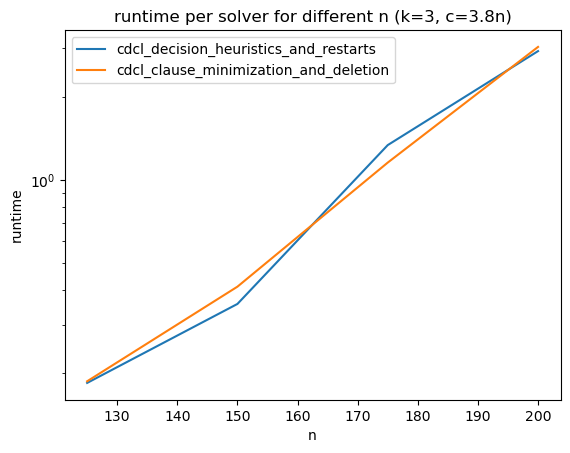

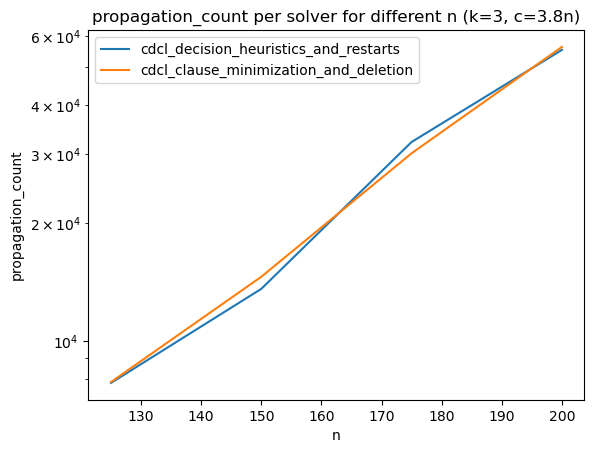

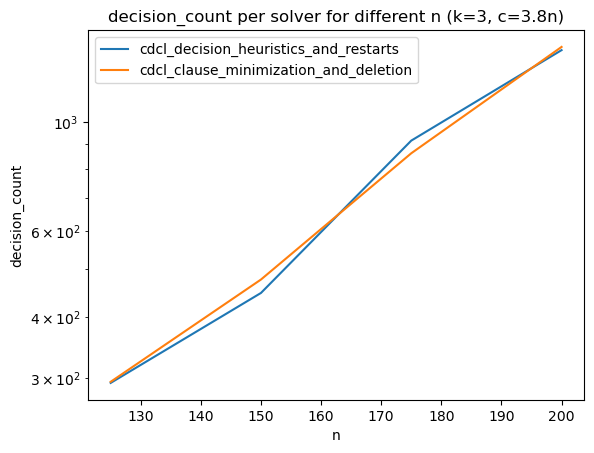

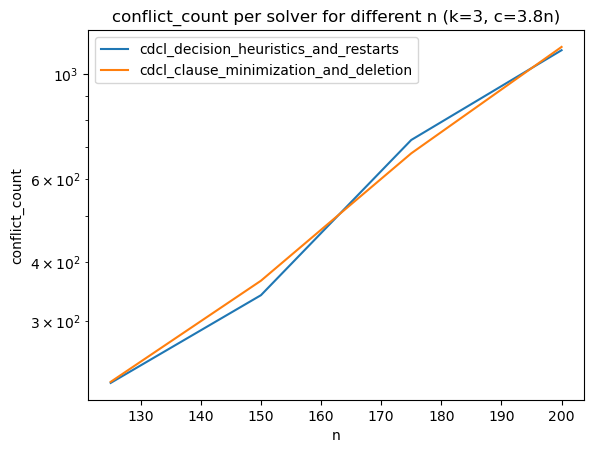

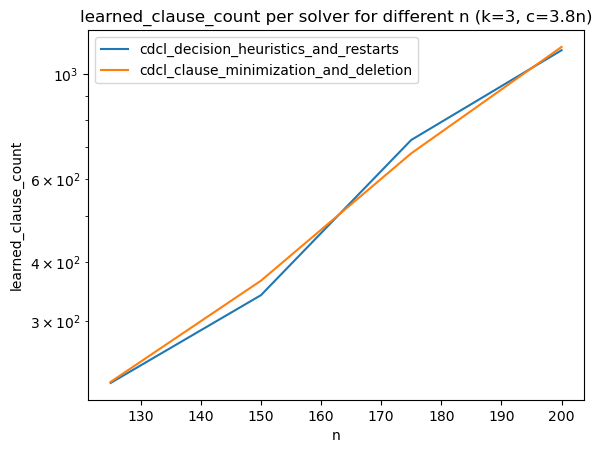

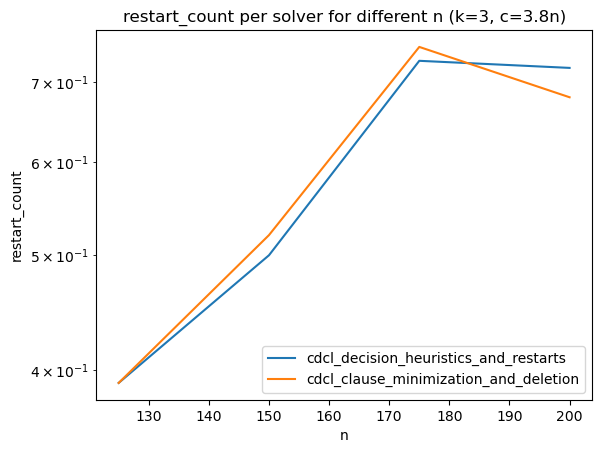

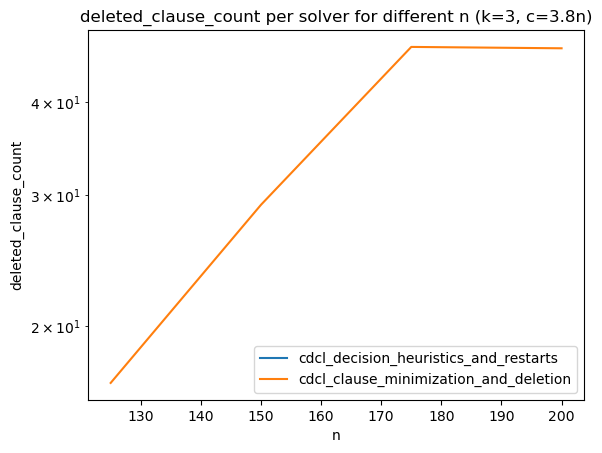

In [10]:
solvers = [cdcl_decision_heuristics_and_restarts,cdcl_clause_minimization_and_deletion]
ns = [125,150,175,200]
last_2_iteration_stats = get_statistics_for_multiple_n(ns,solvers)
avg_last_2_iteration_stats = average_statistics(last_2_iteration_stats)
plot_statistic(avg_last_2_iteration_stats,ns,"runtime")
plot_multiple_statistics(avg_last_2_iteration_stats,ns,["propagation_count", "decision_count", "conflict_count", "learned_clause_count", "restart_count", "deleted_clause_count"])

Nope, my supposition seems to be untrue. Both solvers still seem to perform very similarly. The only difference is that they are not completely identical for some statistics. None of the solvers seems to be able to beat the other as they alternate between being better or worse. The only clear difference I can tell is that the version with clause minimization and deletion almost always requires more restarts than the one without. This might be due to some relevant clauses being deleted.

## Deep-Dive into specific solver hyperparameters

### DPLL

In Lab 4 (DPLL), we wanted to compare DPLL's performance when using pure literal elimination vs. without it. Let's investigate this by comparing the solving speed of the 2 DPLL versions and then looking at statistics such as the numbers of unit propagations, pure literal eliminations and decisions necessary to solve the formulas.

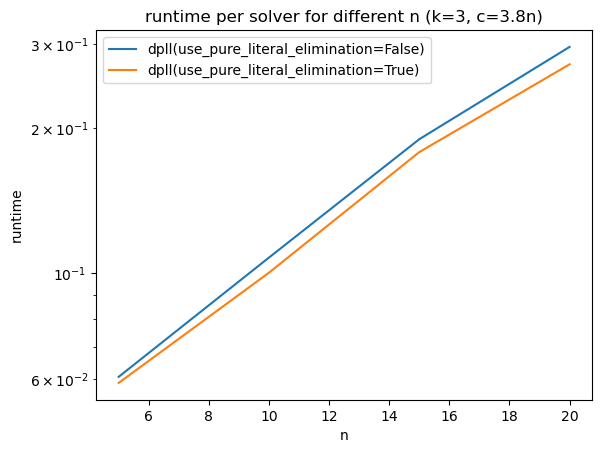

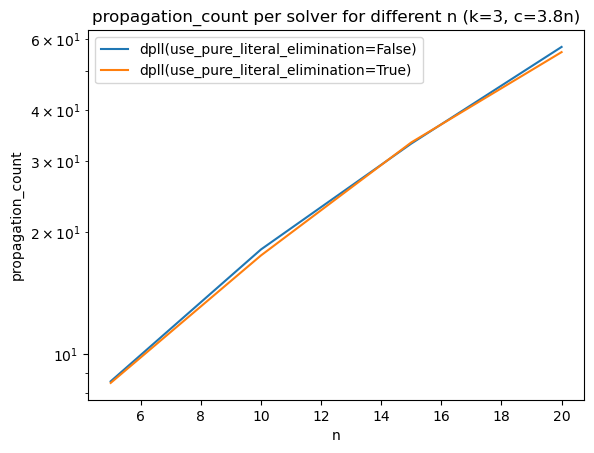

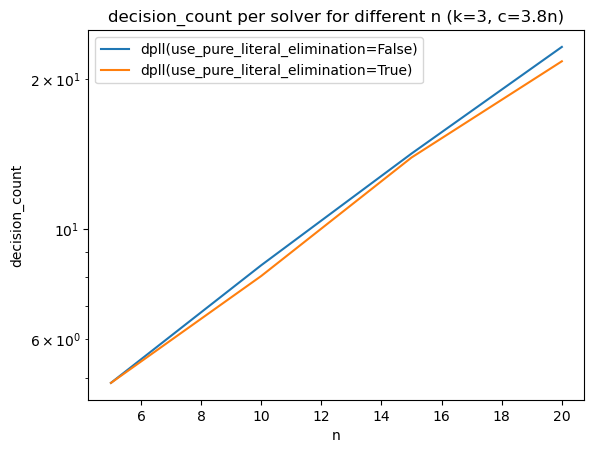

In [ ]:
solvers = [dpll,dpll]
solver_args = [{'use_pure_literal_elimination':True},{'use_pure_literal_elimination':False}]
ns = [5,10,15,20]
outlier_statistics = get_average_statistics_for_multiple_n(ns,solvers,solver_args=solver_args,num_tests=1000)
plot_multiple_statistics(outlier_statistics,ns,["runtime","propagation_count","decision_count"], " (mean)")

It seems that using pure literal elimination does improve dpll's performance but only by a small margin. As expected, using pure literal elimination lowers the amount of necessary unit propagations and decisions. 

I would personally suspect that these performance results are mainly due to an inefficient implementation of unit propagation used in the dpll algorithm. A faster implementation using watched literals may imply that pure literal elimination is not worth-it.

### VSIDS

Let's have a look into how VSIDS affects the performance of the CDCL solver.

## Pigeonhole and Pebbling